In [1]:
%matplotlib inline

### Imports

In [2]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor, Resize, ToPILImage
from torchvision.transforms.functional import to_grayscale, to_tensor
import matplotlib.pyplot as plt

import os
import pandas as pd
from torchvision.io import read_image

from torch.utils.data import DataLoader

import re

### Useful functions to retrive the data

In [25]:
# create a annotations_file.csv (img -> img, label)

def getLabelList(path):
    only_dirs = [ name for name in os.listdir(path) if 
                 os.path.isdir(os.path.join(path, name)) ]

    ret = {}
    
    for d in only_dirs:
        new_path = path + d
        index = only_dirs.index(d)
        for img in [ name for name in os.listdir(new_path) if not
                    name.endswith(".jpg")]:
            ret[img] = [img, index]
    
    return pd.Series(ret)


In [30]:
# create the pool of images (with a series that contains all the images, more deeply: img_name -> abs path, label, classes)

def getImgPool(path):
    only_dirs = [ name for name in os.listdir(path) if 
                 os.path.isdir(os.path.join(path, name)) ]

    ret = {}
    
    for d in only_dirs:
        new_path = path + d
        index = only_dirs.index(d)
        for img in [ name for name in os.listdir(new_path) if not
                    name.endswith(".jpg")]:
            abs_path = new_path + '/' + img
            ret[img] = [abs_path, index, d]
    
    return pd.Series(ret)


### Defining the custom dataset (structure that holds the data)

In [31]:
class CustomImageDataset(Dataset):
    def __init__(self, path_labels, transform=None, target_transform=None, num_of_channels=3):
        self.img_labels = getLabelList(path_labels)
        self.images = getImgPool(path_labels)
        self.transform = transform
        self.target_transform = target_transform
        self.noc = num_of_channels

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_name = self.img_labels.iloc[idx][0]
        image = read_image(self.images.loc[img_name][0])
        if image.shape[0] == 3 and self.noc == 1: #apply grayscale to colored img
            image = to_tensor(to_grayscale(ToPILImage()(image), num_output_channels=self.noc))
        if image.shape[0] == 1 and self.noc == 3: #coloring grayscaled img
            image = to_tensor(to_grayscale(ToPILImage()(image), num_output_channels=self.noc))
        image = Resize((600, 600))(image)
        image = image.permute(1,2,0) #made to be shown on matplotlib
        label = self.img_labels.iloc[idx][1]
        return image, label

### Creating the 2 dataset and testing

In [32]:
train_path = './data/car_brand_logos/Train/'
test_path = './data/car_brand_logos/Test/'

# train_data = CustomImageDataset(path_labels=train_path, transform=ToTensor(), num_of_channels=3)
# test_data = CustomImageDataset(path_labels=test_path, transform=ToTensor(), num_of_channels=3)

train_data = CustomImageDataset(path_labels=train_path, transform=ToTensor(), num_of_channels=1)
test_data = CustomImageDataset(path_labels=test_path, transform=ToTensor(), num_of_channels=1)

C:\Users\eliad\AppData\Local\Temp\ipykernel_10264\3074374005.py:16: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  return pd.Series(ret)
C:\Users\eliad\AppData\Local\Temp\ipykernel_10264\3072499241.py:17: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  return pd.Series(ret)


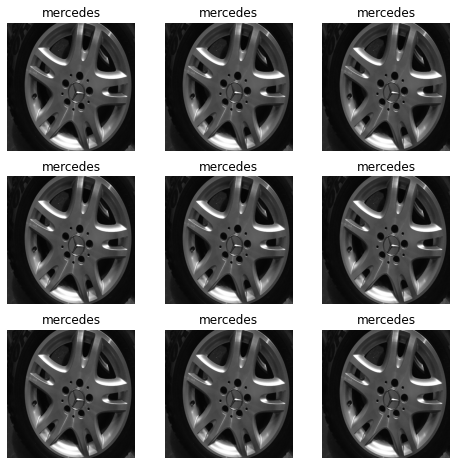

In [33]:
#testing dataset if images are loaded

only_dirs = [ name for name in os.listdir(train_path) if 
                 os.path.isdir(os.path.join(train_path, name)) ]

diz = {}
i=0
for d in only_dirs:
    diz[i] = d
    i+=1

figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_data), size=(1,)).item() 
    img, label = train_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(diz[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap='gray')
    # plt.imshow(img.squeeze())
plt.show()

In [ ]:
# img, label = train_data[300]

# print(img.shape)

# plt.imshow(img.squeeze(), cmap='gray')

### creating dataloader (who iterate on data, create batches and shuffles it)


Feature batch shape: torch.Size([1, 600, 600, 1])
Labels batch shape: torch.Size([1])


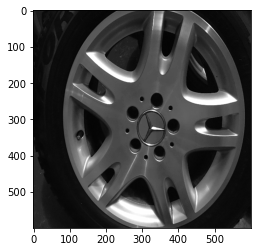

Label: mercedes


In [36]:
train_dl = DataLoader(train_data, batch_size=64, shuffle=True)
# test_dl = DataLoader(test_data, batch_size=64, shuffle=True)

#dataloader test (ask a batch or a sample)

images, labels = next(iter(train_dl)) #picking a batch
print(f"Feature batch shape: {images.size()}")
print(f"Labels batch shape: {labels.size()}")
img = images[0].squeeze() #picking the first img and label of the batch
label = labels[0]
plt.imshow(img, cmap='gray')
plt.show()
print(f"Label: {diz[label.item()]}")